In [ ]:
# Install FastAI
!pip install -q fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.0 MB/s eta 0:00:00


In [ ]:
!pip install -q fastai --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.3/235.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.7 MB/s eta 0:00:00


In [ ]:
# Menambahkan path direktori Kode_Skripsi untuk mengimpor file functions.py
import sys
sys.path.append('/content/drive/MyDrive/Kode_Skripsi')

In [ ]:
!cp /content/drive/MyDrive/Kode_Skripsi/functions.py /content/

cp: cannot stat '/content/drive/MyDrive/Kode_Skripsi/function.py': No such file or directory


#Pre-processing

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, precision_score, accuracy_score, log_loss, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from fastai.tabular.all import *


import os
import functions
import joblib

In [ ]:
# Mengabaikan warning penggunaan processor dan konfigurasi penggunaan weight terbaik dari epoch sebelumnya
functions.ignore_warnings()

In [ ]:
# Mengambil dataset RT IoT 2022
rt_iot2022_6classes = '/content/drive/MyDrive/Dataset_Skripsi/6_Classes/RT_IOT2022_6Classes.csv'

df = pd.read_csv(rt_iot2022_6classes)

# Memisahkan kolom fitur dan target
X = df.drop(columns=['Attack_type'])
y = df['Attack_type']

In [ ]:
# Menyimpan label asli sebelum encoding agar tidak ikut termodifikasi
y_label = y.copy()
# Melakukan encoding label utama (y) sekali untuk StratifiedKFold
y_encoded = LabelEncoder().fit_transform(y.squeeze())

In [ ]:
# Menampilkan hasil encoding
functions.show_label_encoding(y, y_encoded)

===== Mapping Label Encoding (Attack_type) =====
     Label_Original  Label_Encoded
     ARP_poisioning              0
     DDOS_Slowloris              1
  NMAP_OS_DETECTION              2
      NMAP_TCP_scan              3
      NMAP_UDP_SCAN              4
NMAP_XMAS_TREE_SCAN              5


#FastAI

In [ ]:
# Melakukan Stratified K-Fold dengan 5 fold dan hasilnya diacak
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Memastikan folder Model_Skripsi tersedia
os.makedirs("/content/drive/MyDrive/Model_Skripsi/", exist_ok=True)

In [ ]:
# Melakukan inisialisasi untuk menyimpan kurva metrik per epoch dalam setiap fold
fold_logloss_curve = []
fold_accuracy_curve = []

# Melakukan inisialisasi untuk nantinya menyimpan metrik setiap fold
fold_results = {
    'fold': [],
    'accuracy': [],
    'f1_score': [],
    'precision': [],
    'roc_auc': [],
    'log_loss': []
}
evals_result = {}

# Melakukan inisialisasi model terbaik
best_model = None

best_logloss = float('inf')
best_preds = None
best_y_true = None
best_fold = -1

# Melakukan inisialisasi untuk nilai epoch dan patience yang sedang digunakan
n_epochs = 100
n_earlystop = 15

# Melakukan Cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\nFold {fold+1}")
    X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Melakukan split data dan encoding
    for col in X_train.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))
        X_test[col] = X_test[col].astype(str).map(lambda s: le.transform([s])[0] if s in le.classes_ else -1)

    # Membersihkan nilai NaN dan Inf dari data numerik
    num_cols = X_train.select_dtypes(include=np.number).columns

    # Mengisi NaN dengan median
    scaler = StandardScaler()
    X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
    X_test[num_cols] = scaler.transform(X_test[num_cols])

    # Melakukan reconstruct training dan testing DataFrames
    X_train['Attack_type'] = y_train.values
    X_test['Attack_type'] = y_test.values

    procs = [Categorify, FillMissing, Normalize]
    dls = TabularDataLoaders.from_df(pd.concat([X_train, X_test]), path='.', procs=procs,
                                     cat_names=[], cont_names=list(num_cols),
                                     y_names='Attack_type', valid_idx=list(range(len(X_train), len(X_train)+len(X_test))),
                                     bs=1024)

    learn = tabular_learner(dls, metrics=[accuracy, F1Score(average='macro'), Precision(average='macro')], loss_func=CrossEntropyLossFlat())

    # Melakukan training model
    learn.fit_one_cycle(n_epochs, 1e-3, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=n_earlystop)])

    # Simpan nilai logloss dan accuracy di setiap epoch
    metrics_per_epoch = learn.recorder.values  # list of [train_loss, valid_loss, accuracy, f1, precision]
    epoch_logloss = [row[1] for row in metrics_per_epoch]  # valid_loss
    epoch_accuracy = [row[2] for row in metrics_per_epoch]  # accuracy

    fold_logloss_curve.append(epoch_logloss)
    fold_accuracy_curve.append(epoch_accuracy)

    # Melakukan evaluasi pada metrik accuracy, F1-score, dan precision
    preds, targs = learn.get_preds()
    y_pred = preds.argmax(dim=1).numpy()
    y_true = targs.numpy()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    ll = log_loss(y_true, preds.numpy())

    # Menghitung multiclass AUC-ROC
    try:
        auc = roc_auc_score(y_true, preds.numpy(), multi_class='ovr', average='macro')
    except:
        auc = None

    # Menyimpan semua nilai metrik ke dictionary hasil
    fold_results['fold'].append(fold + 1)
    fold_results['accuracy'].append(acc)
    fold_results['f1_score'].append(f1)
    fold_results['precision'].append(precision)
    fold_results['roc_auc'].append(auc)
    fold_results['log_loss'].append(ll)

    if ll < best_logloss:
        best_model = learn
        best_logloss = ll
        best_preds = y_pred
        best_y_true = y_true
        best_fold = fold + 1

    # Menampilkan rata-rata metrik sampai fold saat ini
    print(f"\n   Metrik Fold {fold+1}:")
    print("     Accuracy : {:.6f}".format(acc))
    print("     F1 Score : {:.6f}".format(f1))
    print("     Precision: {:.6f}".format(precision))
    print("     Log Loss : {:.6f}".format(ll))
    print("     ROC AUC  : {:.6f}".format(auc if auc is not None else -1))




Fold 1


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,1.791408,1.746336,0.253420,0.172390,0.154028,00:00
1,1.686371,1.639140,0.563355,0.538743,0.590662,00:00
2,1.563647,1.424504,0.708063,0.684221,0.696544,00:00
3,1.424560,1.140185,0.864291,0.816386,0.789081,00:00
4,1.276319,0.852712,0.920446,0.856779,0.841399,00:00
5,1.124331,0.615872,0.939885,0.899375,0.881639,00:00
6,0.974009,0.443910,0.945644,0.905282,0.888329,00:00
7,0.837592,0.323254,0.962923,0.938345,0.919235,00:00
8,0.714288,0.241197,0.965803,0.941814,0.923507,00:00
9,0.606848,0.185057,0.972282,0.950269,0.933691,00:00


No improvement since epoch 66: early stopping



   Metrik Fold 1:
     Accuracy : 0.989201
     F1 Score : 0.974017
     Precision: 0.990164
     Log Loss : 0.024644
     ROC AUC  : 0.999100

Fold 2


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,1.921288,1.778740,0.187973,0.104479,0.107775,00:00
1,1.803600,1.700518,0.387108,0.264718,0.283868,00:00
2,1.671149,1.494502,0.718401,0.617484,0.631237,00:00
3,1.522864,1.204687,0.914656,0.872465,0.864729,00:00
4,1.364944,0.910871,0.933741,0.893818,0.886237,00:00
5,1.198588,0.667850,0.940583,0.906295,0.889691,00:00
6,1.035416,0.469694,0.958588,0.932442,0.919614,00:00
7,0.882295,0.330773,0.967951,0.945177,0.935002,00:00
8,0.748327,0.250714,0.971552,0.949488,0.940651,00:00
9,0.632658,0.193823,0.975513,0.956838,0.953169,00:00


No improvement since epoch 63: early stopping



   Metrik Fold 2:
     Accuracy : 0.990637
     F1 Score : 0.978688
     Precision: 0.989779
     Log Loss : 0.024843
     ROC AUC  : 0.999534

Fold 3


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,2.013015,1.804010,0.298524,0.167103,0.171245,00:00
1,1.900967,1.744884,0.350738,0.209994,0.260459,00:00
2,1.769488,1.577112,0.522506,0.443164,0.468977,00:00
3,1.616490,1.305714,0.733885,0.634405,0.613388,00:00
4,1.444855,0.994770,0.916097,0.862101,0.859645,00:00
5,1.271209,0.746049,0.957508,0.927679,0.917527,00:00
6,1.102108,0.536181,0.963270,0.940804,0.937115,00:00
7,0.947023,0.391601,0.970472,0.953712,0.950042,00:00
8,0.806312,0.294516,0.973353,0.958424,0.951679,00:00
9,0.683028,0.233412,0.976233,0.962891,0.958897,00:00


No improvement since epoch 57: early stopping



   Metrik Fold 3:
     Accuracy : 0.993158
     F1 Score : 0.987293
     Precision: 0.995519
     Log Loss : 0.031051
     ROC AUC  : 0.998925

Fold 4


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,1.840696,1.786787,0.301764,0.221200,0.218578,00:00
1,1.736202,1.674742,0.564278,0.474909,0.459473,00:00
2,1.617640,1.452068,0.681671,0.554664,0.559780,00:00
3,1.478618,1.152965,0.867483,0.778538,0.757974,00:00
4,1.328828,0.864282,0.924019,0.833960,0.843747,00:00
5,1.168435,0.625426,0.958948,0.934524,0.916289,00:00
6,1.009495,0.445517,0.961469,0.940139,0.922431,00:00
7,0.857928,0.316474,0.961469,0.940255,0.922886,00:00
8,0.728123,0.241524,0.962550,0.940474,0.922671,00:00
9,0.619657,0.193913,0.964350,0.940994,0.923954,00:00



   Metrik Fold 4:
     Accuracy : 0.987757
     F1 Score : 0.972585
     Precision: 0.985789
     Log Loss : 0.028943
     ROC AUC  : 0.999739

Fold 5


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,time
0,1.765927,1.735351,0.321210,0.112548,0.163103,00:00
1,1.665585,1.638955,0.678790,0.525801,0.538065,00:00
2,1.544855,1.436653,0.844076,0.788829,0.778184,00:00
3,1.413463,1.162235,0.876125,0.807608,0.798362,00:00
4,1.266401,0.878012,0.929060,0.887587,0.873299,00:00
5,1.113286,0.628835,0.960029,0.935006,0.927513,00:00
6,0.965133,0.447300,0.969752,0.954381,0.941935,00:00
7,0.826423,0.324536,0.968311,0.945374,0.942318,00:00
8,0.704362,0.250797,0.974433,0.957059,0.955854,00:00
9,0.600178,0.197875,0.976593,0.956201,0.958481,00:00


No improvement since epoch 42: early stopping



   Metrik Fold 5:
     Accuracy : 0.987757
     F1 Score : 0.978020
     Precision: 0.970356
     Log Loss : 0.034722
     ROC AUC  : 0.999410


In [ ]:
# Menyimpan model terbaik pada database
if best_model is not None:
    if n_epochs == 100 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/FastAI/epoch_100/RT-IoT-2022_fastai_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"
    elif n_epochs == 50 and n_earlystop == 15:
        best_model_path = f"/content/drive/MyDrive/Model_Skripsi/FastAI/epoch_50/RT-IoT-2022_fastai_best_model_fold{best_fold}_logloss{best_logloss:.6f}.pkl"


    learn.export(best_model_path)
    print(f"Model terbaik disimpan dari Fold {best_fold} dengan logloss: {best_logloss:.6f}")
    print(f"Model disimpan di path: {best_model_path}")

Model terbaik disimpan dari Fold 1 dengan logloss: 0.024644
Model disimpan di path: /content/drive/MyDrive/Model_Skripsi/FastAI/epoch_100/RT-IoT-2022_fastai_best_model_fold1_logloss0.024644.pkl


In [ ]:
# Rata-rata metrik
print("\nRata-Rata Hasil Cross Validation:")
for metric in ['accuracy', 'f1_score', 'precision', 'roc_auc', 'log_loss']:
    avg_value = np.mean([val for val in fold_results[metric] if val is not None])
    print(f"{metric}: {avg_value:.4f}")


Rata-Rata Hasil Cross Validation:
accuracy: 0.9897
f1_score: 0.9781
precision: 0.9863
roc_auc: 0.9993
log_loss: 0.0288


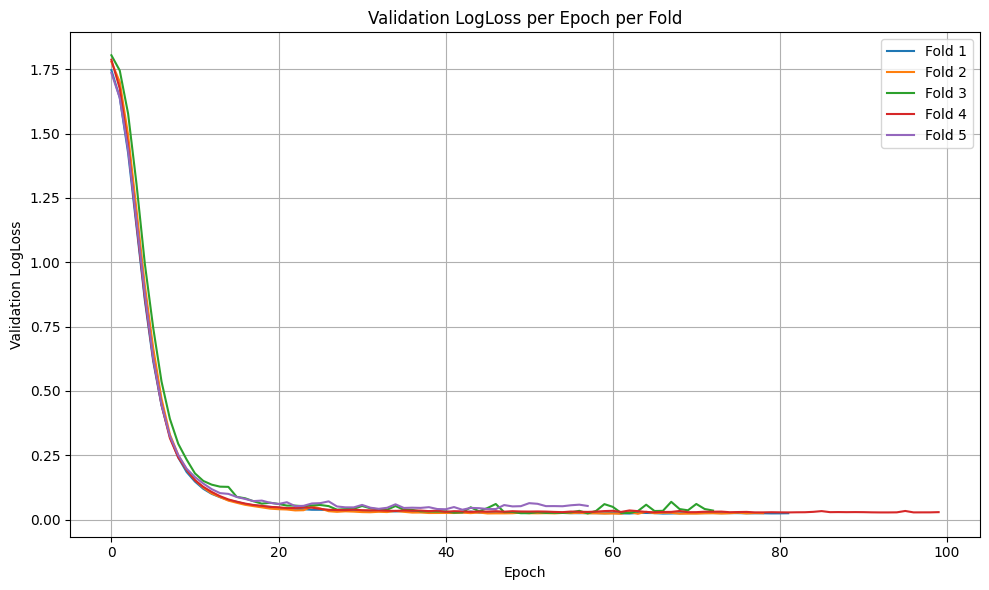

In [ ]:
# Melakukan visualisasi grafik validation logLoss per epoch per Fold
functions.plot_curve(fold_logloss_curve, 'Validation LogLoss')

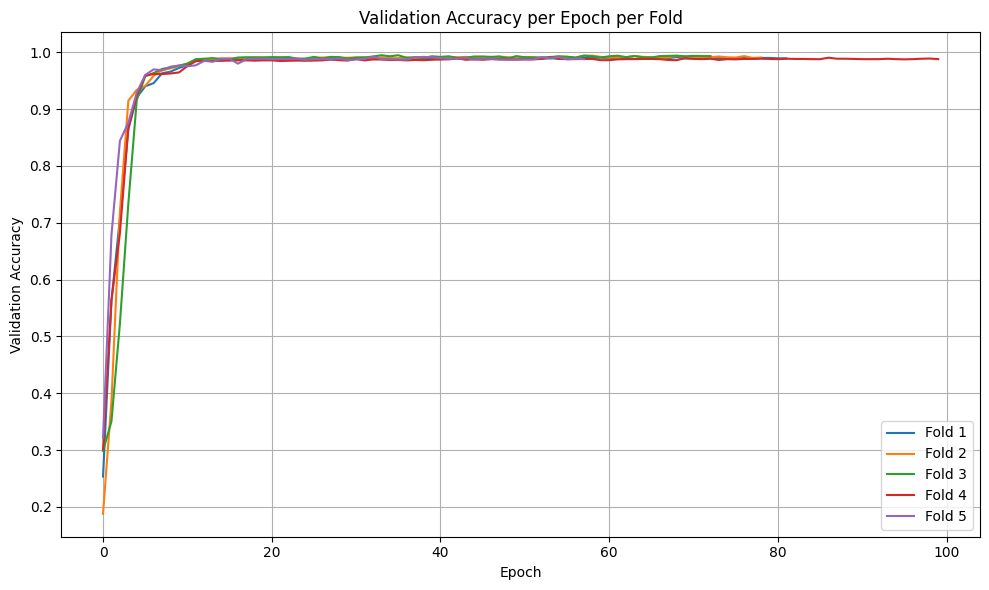

In [ ]:
# Melakukan visualisasi grafik validation accuracy per epoch per Fold
functions.plot_curve(fold_accuracy_curve, 'Validation Accuracy')

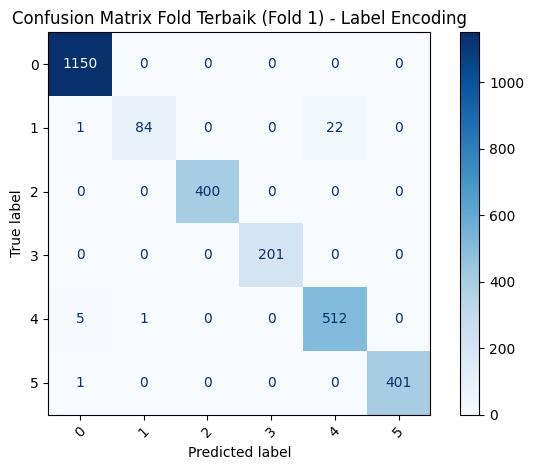

In [ ]:
# Menampilkan visualisasi keakuratan prediksi model
functions.plot_best_confusion_matrix_fastai(best_y_true, best_preds, best_fold)